# Final Project: Modelling

Pada tahun 2022, pendapatan dari pasar kecantikan mencapai sekitar \\$430 miliar. Saat ini, industri kecantikan menunjukkan tren pertumbuhan positif di semua kategori. Dengan pemulihan setelah pandemi, diprediksikan bahwa pendapatan pasar kecantikan akan mencapai sekitar \\$580 miliar di tahun 2027, dengan pertumbuhan tahunan yang diestimasi sebesar 6%.
Dengan potensi tersebut, kami tertarik untuk membuat sistem rekomendasi produk pada *beauty commerce* berdasarkan filterisasi berbasis konten guna meningkatkan penjualan melalui rekomendasi produk yang relevan dan sesuai.


**Pickr** adalah sebuah fitur rekomendasi terpersonalisasi menggunakan teknologi Machine Learning (ML), untuk membantu pengguna menemukan produk yang sesuai dan relevan dengan preferensi dan kata kunci terkait produk yang diinginkan.

Dataset: [Link](https://www.kaggle.com/datasets/raghadalharbi/all-products-available-on-sephora-website)  
Deploy: [Link](https://pickrapp.streamlit.app/)

Anggota tim:
- Destriana Ramadani (Data Engineer)
- Elia Oktaviani (Data Analyst)
- Gita Pramoedya Sastri (Data Scientist)
- Wilona Natalie Elvaretta (Data Scientist)


---
## Import Libraries

Sebelum mejalankan program, library yang dibutuhkan untuk modelling akan di-import terlebih dahulu.

In [1]:
# General use
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from bing_image_urls import bing_image_urls
from urllib.request import urlopen
from PIL import Image
from io import BytesIO
import requests

# Model saving
import pickle

## Cleaned Data Loading

Data yang sudah melalui proses cleaning akan di-load ke dalam notebook. Sebagai recap, cleaning yang dilakukan sebelumnya mencakup:
- Menghapus extra white space dan new line
- Mengubah semua kata ke dalam huruf cetak kecil
- Menggabungkan beberapa kolom
- Tokenisasi kata
- Menghapus stopwords
- Lematisasi kata

Data akan disimpan ke dalam dataframe `df`.

In [2]:
# Assign data to df
df = pd.read_csv('sephora_website_clean.csv')
df.head()

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer,new_category,brand_details_category,preprocessing_brand_details_category
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0,mini,acqua di parma this enchanting set comes in a ...,acqua di parma enchanting set comes specially ...
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0,fragrance,acqua di parma an elegant timeless scent fille...,acqua di parma elegant timeless scent filled f...
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0,fragrance,acqua di parma fragrance family: fresh scent t...,acqua di parma fragrance family fresh scent ty...
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0,fragrance,acqua di parma panarea near sicily is an an is...,acqua di parma panarea near sicily island susp...
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0,mini,acqua di parma the colonia miniature set comes...,acqua di parma colonia miniature set comes ico...


In [3]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168 entries, 0 to 9167
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    9168 non-null   int64  
 1   brand                                 9168 non-null   object 
 2   category                              9168 non-null   object 
 3   name                                  9168 non-null   object 
 4   size                                  9168 non-null   object 
 5   rating                                9168 non-null   float64
 6   number_of_reviews                     9168 non-null   int64  
 7   love                                  9168 non-null   int64  
 8   price                                 9168 non-null   float64
 9   value_price                           9168 non-null   float64
 10  url                                   9168 non-null   object 
 11  marketingflags   

Terlihat ada kolom `brand_details_category` yang merupakan gabungan dari 3 kolom, dan `preprocessing_brand_details_category` yang dihasilkan dari proses text preprocessing (kecuali untuk nama brand untuk mempertahankan keutuhan namanya). Akan dilihat perbedaan dari keduanya.

In [4]:
# Compare columns
df[['brand_details_category', 'preprocessing_brand_details_category']]

,brand_details_category,preprocessing_brand_details_category
0,acqua di parma this enchanting set comes in a ...,acqua di parma enchanting set comes specially ...
1,acqua di parma an elegant timeless scent fille...,acqua di parma elegant timeless scent filled f...
2,acqua di parma fragrance family: fresh scent t...,acqua di parma fragrance family fresh scent ty...
3,acqua di parma panarea near sicily is an an is...,acqua di parma panarea near sicily island susp...
4,acqua di parma the colonia miniature set comes...,acqua di parma colonia miniature set comes ico...
...,...,...
9163,sephora collection what it is: a limited-editi...,sephora collection limited edition nurturing h...
9164,sephora collection what it is: a set of three ...,sephora collection set three bestselling color...
9165,sephora collection what it is: a weightless co...,sephora collection weightless complexion boost...
9166,sephora collection what it is:- available in d...,sephora collection available denominations inc...


Kolom `preprocessing_brand_details_category` sudah melalui text-preprocessing, ditandai dengan beberapa kata yang hilang seperti: this, an, the, serta tanda baca yang sudah tidak ada (kecuali merupakan bagian dari nama brand).  
Kolom ini yang akan dipakai selanjutnya untuk modelling.

## Modelling: TF-IDF

Algoritma yang dipakai untuk modelling adalah **TF-IDF (Term Frequency - Inverse Document Frequency)**.  
TF-IDF merupakan salah satu metode word embedding dalam NLP yang dapat mengubah kata atau kalimat menjadi sebuah vektor. Vektor ini nantinya dapat dipakai untuk menghitung cosine similarity dengan vektor lainnya. Dengan kata lain, kita bisa menggunakan TF-IDF untuk membandingkan 2 kalimat dan mencari kedekatannya.

Atas basis ini, project kami menggunakan TF-IDF untuk mencari kemiripan antara input user (query) dengan kolom `preprocessing_brand_details_category`, dan menggunakannya untuk mencari produk yang paling relevan dengan permintaan user. Sebagai output, akan ditampilkan produk dan karakteristiknya.

Pertama-tama, model TF-IDF akan di-train dengan kolom `preprocessing_brand_details_category` untuk keseluruhan produk.

In [5]:
# Training TF-IDF 
tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 2, stop_words = "english")
tfidf_df = tfidf.fit(df['preprocessing_brand_details_category'])

Misalkan user menggunakan filter untuk mempersempit atau mengerucutkan pencariannya. Dalam contoh ini, user akan hanya mencari produk dengan harga di bawah $100 dengan rating 4 ke atas.  
Filter dari user akan disimpan ke dalam data baru, yaitu `df_filter`.

In [6]:
# User filtering example, make new df
df_filter = df[(df['price'] < 100) & (df['rating'] >= 4.0)]

Contoh di bawah adalah jika user memasukkan `ornge lime powdry` sebagai input. 

Sebagai langkah awal, jika filtering user tidak menghasilkan produk apapun, user akan diberi pesan untuk mengganti inputnya.  
Namun jika terdapat produk dalam filter tersebut, akan dijalankan model untuk mengeluarkan produk yang relevan dengan input user dan sesuai dengan filter yang sudah di-apply.  

Kemudian, query user akan diproses dengan `TextBlob` untuk dikoreksi jika ada typo. Setelah itu, query user dan data hasil filter di-transform dengan TF-IDF yang sudah di-train sebelumnya dengan data lengkap. Kemudian, dicari nilai cosine similarity antara transformed query dengan transformed data filter. Diambil 5 produk dengan nilai cosine similarity tertinggi sebagai rekomendasi. 

In [7]:
# Modelling & recommending

if len(df_filter) == 0:
    print('Sorry, no products matched your request. Please try other keywords or use the filter on the left of this page.')
else:
    # Sample query
    query = 'ornge lime powdry'
    blob = TextBlob(query)

    # Corrected query to string
    corrected_query = str(blob.correct())
    
    # Vectorize query
    corrected_query_vec = tfidf_df.transform([corrected_query])

    # TF-IDF transform filtered data
    tfidf_df_filter = tfidf_df.transform(df_filter['preprocessing_brand_details_category'])

    # Calculate cosine similarity
    recommendation = cosine_similarity(tfidf_df_filter, corrected_query_vec).reshape((-1, ))
    df_filter['similarity'] = recommendation

    # Save result indices 
    recommendation_index = []
    for i in recommendation.argsort()[-8:][::-1]:
        if recommendation[i] >= 0.1:
            recommendation_index.append(i)
        else:
            pass
    if len(recommendation_index) == 0:
        print('Sorry, no products matched your request. Please try other keywords or use the filter on the left of this page.')
    else:
        # Show recommended products
        df_recommendation = df_filter.iloc[recommendation_index]
        df_recommendation['url_image'] = 'https://st4.depositphotos.com/14953852/24787/v/450/depositphotos_247872612-stock-illustration-no-image-available-icon-vector.jpg'
        for i in range(len(df_recommendation)):
            image_query = df_recommendation.iloc[i, 1] + df_recommendation.iloc[i, 3]
            image_urls = bing_image_urls(image_query, limit = 3)
            image_url = ''
            for j in image_urls:
                if len(j) > 0:
                    image_url = j
                    break
                else:
                    pass
            df_recommendation.iloc[i, 25] = image_url
        display(df_recommendation[['brand', 'category', 'name', 'details', 'similarity', 'url_image']])

,brand,category,name,details,similarity,url_image
3486,HERMÈS,Perfume,Eau de citron noir Eau de Cologne,Fragrance Family: FreshScent Type: Fresh Citru...,0.165247,https://perfumediary.com/wp-content/uploads/20...
472,Atelier Cologne,Fragrance,Perfume Stories Mini Set,Fragrance Description: Perfume has the power t...,0.139638,https://1.bp.blogspot.com/-bMSm2peQPac/YBmDYzJ...
466,Atelier Cologne,Fragrance,Mini Perfume Wardrobe Set,Fragrance Description: Pacific Lime is a tropi...,0.137868,https://johnlewis.scene7.com/is/image/JohnLewi...
3165,Givenchy,Lipstick,Le Rouge Deep Velvet Lipstick,What it is: A highly pigmented- powdery matte-...,0.132922,https://media1.popsugar-assets.com/files/thumb...
6263,Origins,Perfume,Ginger Essence™ Sensuous Skin Scent,What it is:A fiery scent featuring spicy ginge...,0.131492,https://i.pinimg.com/originals/cd/e7/61/cde761...
506,Atelier Cologne,Lotions & Oils,Orange Sanguine Moisturizing Body Lotion,What it is:\nA moisturizing body lotion with a...,0.122682,https://image.harrods.com/atelier-cologne-oran...
3199,Givenchy,Eyebrow,Eyebrow Pencil,What it is: A powdery matte-finish eyebrow pen...,0.119497,https://images.beautyandmakeupmatters.com/2016...
5832,Narciso Rodriguez,Rollerballs & Travel Size,Pure Musc Eau de Parfum Travel Spray,Fragrance Family: FloralScent Type: Powdery Fl...,0.118460,https://mobilefragrance.com/wp-content/uploads...


Walaupun similarity terlihat kecil, hasil yang dikeluarkan oleh model masih relevan dengan query. Ini membuat kami tetap yakin bahwa model masih bekerja dengan baik untuk merekomendasikan produk yang sesuai dengan keinginan user.

Ditambahkan kolom `url_image` untuk keperluan deployment model nantinya. Berikut adalah contoh gambar dari hasil fetching URL.

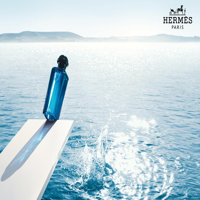

In [8]:
# Display image from URL
df_recommendation.reset_index(inplace = True)
url = df_recommendation['url_image'][0]
r = requests.get(url)
pilImage = Image.open(BytesIO(r.content))
pilImage.resize((200, 200))

## Model saving

Akan disimpan TF-IDF vectorizer yang sudah di-train dengan katalog produk di dataset.

In [9]:
# Saving
with open('pickr.pkl', 'wb') as file_1: 
  pickle.dump(tfidf_df, file_1)

## Conclusion

Dari proses modelling, ada beberapa poin yang perlu di-highlight:
- TF-IDF dan perhitungan cosine similarity berjalan dengan baik tanpa error
- Nilai cosine similarity cenderung kecil, walaupun produk yang dihasilkan masih relevan jika dinilai secara subjektif
- Tidak semua typo dikoreksi dengan benar, seperi citris yang seharusnya citrus, malahan menjadi cities
- URL yang di-fetch dengan Bing API terkadang tidak relevan (contoh: seharusnya gambar produk, tetapi ada gambar manusia) dan berubah-ubah tiap program dijalankan


Saran untuk pengembangan atau perbaikan project ini ke depannya:
- Menambah lebih banyak produk ke katalog produk, untuk menyediakan lebih banyak opsi rekomendasi pada user
- Menggunakan metode lain untuk handling typo, atau menambahkan kata-kata tertentu ke dalam library kata yang sering typo (dalam kasus ini yang berkaitan dengan ranah beauty) 
- Menggunakan API search image yang lebih baik, agar hasil gambar yang dikeluarkan selalu relevan dengan produk. Jika tidak mengambil link gambar produk, dapat dilakukan scraping terlebih dahulu dan memasukkan setiap gambar produk ke masing-masing row data
- Mengambil kata yang penting saja dari kolom `preprocessing_brand_details_category`, dengan harapan nilai cosine similarity dengan user input bisa lebih tinggi 
- Mengaplikasikan semantics search di modelling, misalkan dengan menggunakan Word2Vec, Doc2Vec, LSI, dan lain-lain. Ini diharapkan dapat menghasilkan searching yang lebih baik dibandingkan dengan TF-IDF
